15.  OCR 모델 비교

다운로드할 모듈들을 먼저 다운로드 한다.

conda install -c anaconda keras-ocr

pip install keras-ocr

conda install -c conda-forge matplotlib

conda install -c anaconda numpy

Keras_ocr부터 먼저 사용하여 인식하고 그 결과를 matplotlib.pyplot을 통해 시각화한다

-> keras_ocr.pipeline.Pipeline()을 통해 초기화과정에서 미리 학습된 모델의 가중치를 불러온다, 검출기, 인식기를 위한 각각의 가중치 

In [1]:
import numpy

In [2]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [18]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  #'https://source.unsplash.com/M7mu6jXlcns/640x460',
  #'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  #'https://source.unsplash.com/98uYQ-KupiE',
  #'https://source.unsplash.com/j9JoYpaJH3A',
  #'https://source.unsplash.com/eBkEJ9cH5b4',
    'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F992346475A989CC61F'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

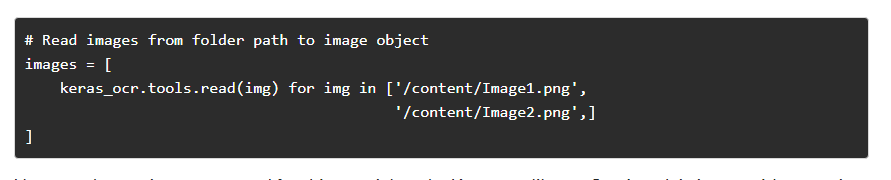
다음의 이미지 입력을 따라하겠다

In [57]:
img_path=os.getenv("HOME")+'/aiffel/ocr_python'
image_datas = [img_path+'/mr_noise.png',
              img_path+'/love.png',
              img_path+'/pytorch_noise2.png',
              img_path+'/GoogleAPI_noise.png',
              img_path+'/Tesseract_noise3.png',
              img_path+'/txtimg.png']

In [58]:
images = [ keras_ocr.tools.read(img) for img in image_datas]
prediction_groups = [pipeline.recognize([img]) for img in image_datas] 

이미지에 recognize를 통해 검출기로 바운딩박스를 검출 -> 인식기가 각 박스 내의 문자를 인식한다

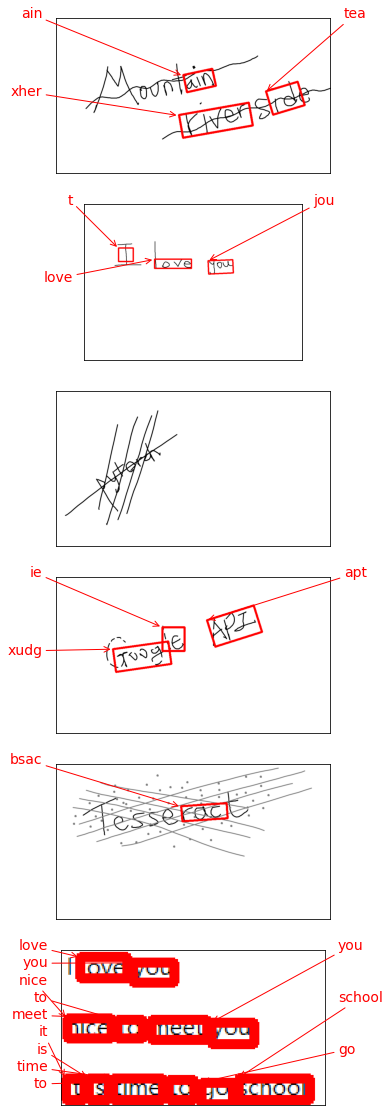

In [59]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

노이즈에 대해서 아주 정확하게 배제할수 있는 느낌은 아니다. 
어떤 이미지에 대해서는 아예 인식 바운더리박스조차 검출하지 못한 상황이 나온다

그래서 정상 단어 이미지에 대해서 검출하였을 때에는 아주 잘 검출되는 모습이 나온다 대신, 시간이 오래걸린다

Tesseract 설치

conda install -c conda-forge tesseract

conda install -c conda-forge libtesseract-dev

Tesseract 파이썬 wrapper 설치 -> OS에 설치된 태서랙트를 파이썬에서 쉽게 사용해줄수 있도록 하는 라이브러리

conda install -c conda-forge pytesseract

In [28]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv("HOME")+'/aiffel/ocr_python'
img_file_path = work_dir + '/love.png'#'/15_3.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir+'/storage')

/aiffel/aiffel/ocr_python/storage/0000.png
/aiffel/aiffel/ocr_python/storage/0001.png
/aiffel/aiffel/ocr_python/storage/0002.png
/aiffel/aiffel/ocr_python/storage/0003.png


In [45]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

|

Ove

9

Kh

Done


In [52]:
from PIL import Image

/aiffel/aiffel/ocr_python/mr_noise.png그림에 대한 결과


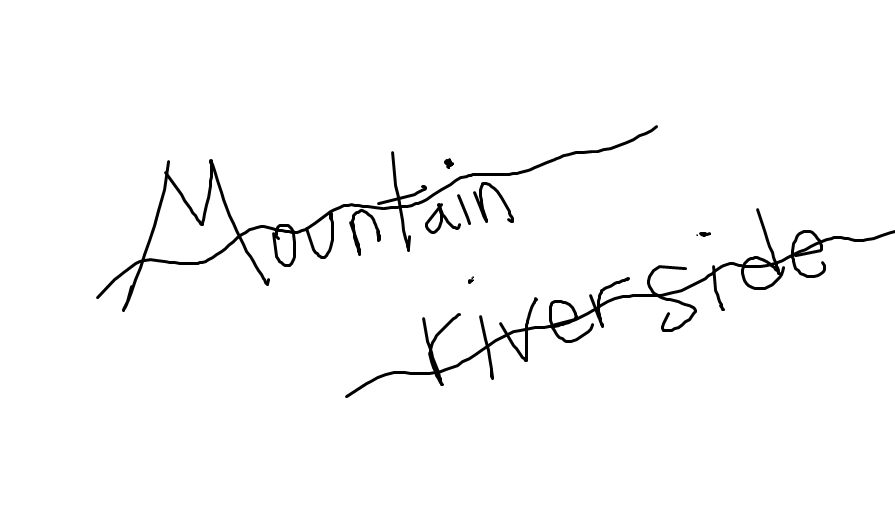

/aiffel/aiffel/ocr_python/storage/0000.png
ro ese

Done
/aiffel/aiffel/ocr_python/love.png그림에 대한 결과


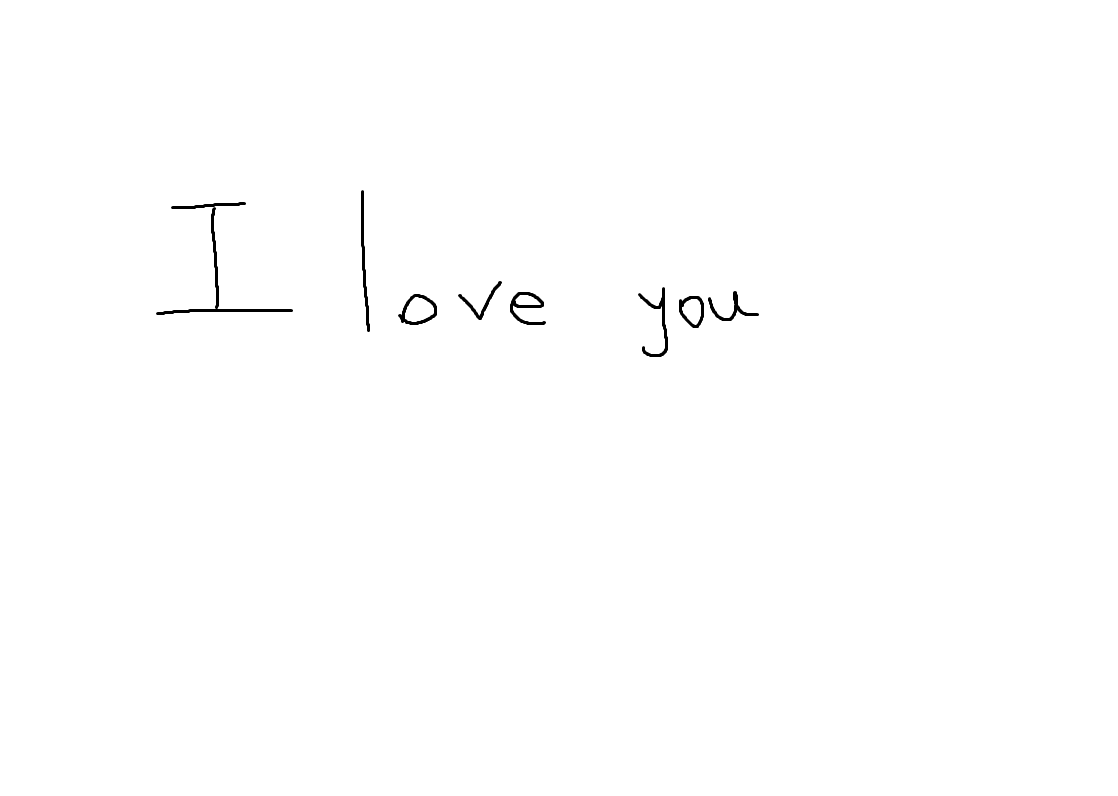

/aiffel/aiffel/ocr_python/storage/0000.png
/aiffel/aiffel/ocr_python/storage/0001.png
/aiffel/aiffel/ocr_python/storage/0002.png
/aiffel/aiffel/ocr_python/storage/0003.png
|

Ove

9

Kh

Done
/aiffel/aiffel/ocr_python/pytorch_noise2.png그림에 대한 결과


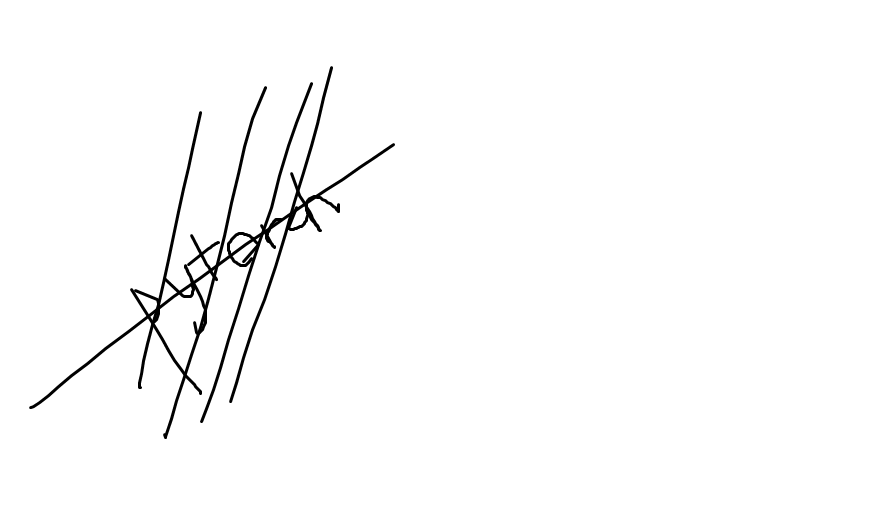

/aiffel/aiffel/ocr_python/storage/0000.png
vs

Done
/aiffel/aiffel/ocr_python/GoogleAPI_noise.png그림에 대한 결과


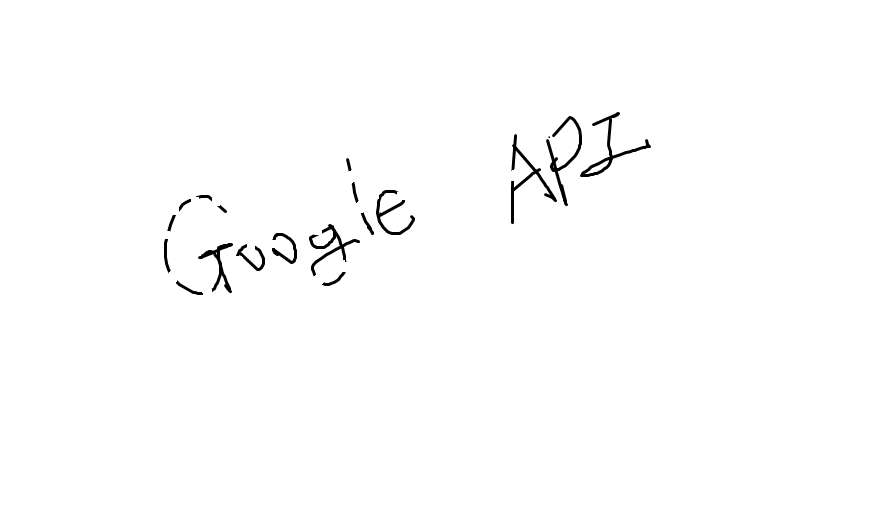

/aiffel/aiffel/ocr_python/storage/0000.png
/aiffel/aiffel/ocr_python/storage/0001.png
/aiffel/aiffel/ocr_python/storage/0002.png
/aiffel/aiffel/ocr_python/storage/0003.png
\e

We


408

Done
/aiffel/aiffel/ocr_python/txtimg.png그림에 대한 결과


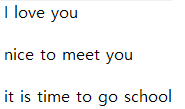

/aiffel/aiffel/ocr_python/storage/0000.png
/aiffel/aiffel/ocr_python/storage/0001.png
/aiffel/aiffel/ocr_python/storage/0002.png
/aiffel/aiffel/ocr_python/storage/0003.png
/aiffel/aiffel/ocr_python/storage/0004.png
/aiffel/aiffel/ocr_python/storage/0005.png
/aiffel/aiffel/ocr_python/storage/0006.png
/aiffel/aiffel/ocr_python/storage/0007.png
/aiffel/aiffel/ocr_python/storage/0008.png
/aiffel/aiffel/ocr_python/storage/0009.png
/aiffel/aiffel/ocr_python/storage/0010.png
/aiffel/aiffel/ocr_python/storage/0011.png
| love

yOu

NIC

ce

tO

meet

yOu

iS

time

tO

QO

school

Done


In [60]:
work_dir = os.getenv("HOME")+'/aiffel/ocr_python'
img_files_paths = [work_dir+'/mr_noise.png',
              work_dir+'/love.png',
              work_dir+'/pytorch_noise2.png',
              work_dir+'/GoogleAPI_noise.png',
              work_dir+'/txtimg.png']#'/15_3.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

for img_file_path in img_files_paths:
    print(img_file_path+'그림에 대한 결과')
    img_show = Image.open(img_file_path)
    img_show.show()
    cropped_image_path_list = crop_word_regions(img_file_path, work_dir+'/storage')
    recognize_images(cropped_image_path_list)

# 결론
keras-ocr, tesseract 두 모듈 모두 노이즈에 대해서 단어를 정확히 뽑아내진 못한다.

그래서 정상적인 text image를 가지고 좀더 잘 구분 한 것을 사용하려 했다.

정상적인 이미지에 대해서 좀더 잘 구분한 것은 keras-ocr이였다. 

내가 구현하고자 하는 서비스는 유통기한이 적힌 이미지에 대해서 정확하게 구별해내는것을 목표로 두고있다. 

그런 관점에서 정확성이 높은것이 더 좋다고 생각된다.. 하지만 속도가 이정도로 느리면 다시 고려해야 될 것 같다.


